In [1]:
from pfd_toolkit import load_reports, LLM, Screener, Extractor
from pydantic import BaseModel, Field

In [2]:
reports = load_reports(end_date="2025-11-25",
                       refresh=True)

print(f"In total, there were {len(reports)} PFD reports published between July 2013 and 25th November 2025.")

In total, there were 6043 PFD reports published between July 2013 and 25th November 2025.


In [3]:
from dotenv import load_dotenv
import os

# Load OpenAI API key from local environment
load_dotenv("api.env")
openai_api_key = os.getenv("OPENAI_API_KEY")

# Initialise LLM client
llm_client = LLM(api_key=openai_api_key, 
                 max_workers=30, 
                 model="gpt-4.1-mini",
                 seed=123, 
                 temperature=0, 
                 timeout=60)

In [4]:
# Set up Screener
search_query = """
Suicide deaths, where the coroner raised at least one concern with suicide safety planning. This **must** exist as a literal plan/document, rather than planning for suicide safety more broadly.
"""


screener = Screener(llm=llm_client, reports=reports)

safety_planning_reports = screener.screen_reports(search_query=search_query)


Sending requests to the LLM: 100%|██████████| 6043/6043 [01:50<00:00, 54.54it/s]


15911 total tokens
15911 total tokens within the threshold.


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Report length distribution'}, xlabel='Tokens count', ylabel='Number of reports'>)

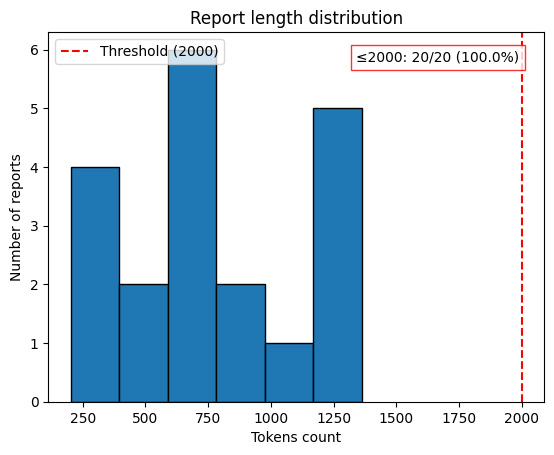

In [9]:
# Discover themes

extractor = Extractor(llm=llm_client,
                      reports=safety_planning_reports)

extractor.count(measure = "tokens", as_ = "hist", threshold=2000)

In [6]:
extra_instructions = """
I'm interested in themes related to **formal** suicide safety plans/documents (as opposed to suicide safety planning more generally).
"""

IdentifiedThemes = extractor.discover_themes(trim_approach="truncate",
                          extra_instructions=extra_instructions)

print(extractor.identified_themes)

```json
{
  "acct_completion": {
    "type": "bool",
    "description": "Failure to fully complete or update ACCT (Assessment, Care in Custody and Teamwork) suicide prevention documents and care plans."
  },
  "acct_reviews": {
    "type": "bool",
    "description": "Inadequate, missed, or improperly conducted ACCT case reviews, including lack of multidisciplinary involvement."
  },
  "acct_observations": {
    "type": "bool",
    "description": "Failure to carry out required ACCT observations or meaningful checks as per suicide prevention protocols."
  },
  "safety_plan_changes": {
    "type": "bool",
    "description": "Changes to formal safety plans or ACCT care plans without proper risk assessment or documentation."
  },
  "risk_communication": {
    "type": "bool",
    "description": "Poor communication or sharing of suicide risk information documented in formal plans between staff, teams, or agencies."
  },
  "training_deficiencies": {
    "type": "bool",
    "description": "Lack

In [7]:
themed_reports = extractor.extract_features(
                              feature_model=IdentifiedThemes,
                              force_assign=True,
                              allow_multiple=True)

extractor.tabulate()

Extracting features: 100%|██████████| 20/20 [00:02<00:00,  8.53it/s]


,Category,Count,Percentage
0,acct_completion,5,25.0
1,acct_reviews,8,40.0
2,acct_observations,6,30.0
3,safety_plan_changes,3,15.0
4,risk_communication,14,70.0
5,training_deficiencies,9,45.0
6,document_integrity,4,20.0
7,plan_accessibility,5,25.0
8,multiagency_involvement,9,45.0
9,post_discharge_planning,3,15.0


In [8]:
themed_reports.to_csv('../data/safety_planning_reports.csv')